## Preparing the enviroment

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [2]:
# diretório do córpus
%cd /content/drive/MyDrive/Mestrado/NLP_2024/TP_LLM

/content/drive/MyDrive/Mestrado/NLP_2024/TP_LLM


In [3]:
# model hyperparameters
config = {
    'd_model': 64,
    'n_heads': 8,
    'n_layers': 6,
    'context_window': 22,
    'epochs': 100,
    'log_interval': 10,
}

## Carregamento e pré-processamento dos dados

---
Nessa seção, ocorrem as seguites etapas:


1.   Teinamento do tokenizador no córpus. O tokenizador utilizado utilizado foi o `sentencepiece` com o algoritmo `Byte-pair encoding`.
2.   Todo o córpus é tokenizado, e o vocabulário é construído a partir do conjunto de tokens originado.
3. O dataset é montado a partir da tokenização do córpus.
4. Partição do dataset em treino, teste e validação.
5. Transformação dessas partições para o tipo `Dataloader` do Pytorch, a fim de facilitar o treinamento em batches.





In [15]:
# ! pip install sentencepiece
import sentencepiece as spm

In [ ]:
# treinamento do tokenizador SentencePiece
spm.SentencePieceTrainer.Train('--input=./input.txt --model_prefix=tiny_shakespeare --vocab_size=8000 --model_type=bpe')

In [16]:
# carregamento do tokenizador
tokenizer = spm.SentencePieceProcessor()
tokenizer.load('tiny_shakespeare.model')

True

In [17]:
# construção do vocabulário (criação do vocabulário)
lines = open('./input.txt', 'r').read()  # Lê o conteúdo do arquivo de entrada

vocab = sorted(set(tokenizer.EncodeAsPieces(lines)))  # Codifica o texto e cria um conjunto único e ordenado de tokens
itos = {i:ch for i, ch in enumerate(vocab)}  # Dicionário que mapeia índices para tokens (índice -> caractere)
stoi = {ch:i for i, ch in enumerate(vocab)}  # Dicionário que mapeia tokens para índices (caractere -> índice)
print('tamanho do vocabulário:', len(vocab))  # Imprime o tamanho do vocabulário (número de tokens únicos)

tamanho do vocabulário: 7268


In [18]:
def encode(s):
    # Codifica uma string `s` em uma lista de índices inteiros.
    return [stoi[token] for token in tokenizer.EncodeAsPieces(s)]

def decode(l):
    # Decodifica uma lista de índices inteiros `l` de volta para uma string.
    return ''.join([itos[i] for i in l])

In [ ]:
encode("hello")

[4670, 1160]

In [ ]:
config

{'d_model': 64,
 'n_heads': 8,
 'n_layers': 6,
 'context_window': 22,
 'epochs': 100,
 'log_interval': 10,
 'vocab_size': 7268,
 'batch_size': 32}

In [19]:
# construção do dataset a partir do córpus tokenizado e update das configs com o tamanho do vocbulário
config.update({
   "vocab_size": len(vocab),
})

dataset = torch.tensor(encode(lines), dtype=torch.int16)
dataset.shape

torch.Size([279996])

In [33]:
# Define a função para montar os splits de teste, treino e validação do dataset
def mount_dataset_splits(data, context_window, config=config):

  # Calcula o tamanho de 80% do dataset para o treino
  train = data[:int(.8 * len(data))]
  # Calcula o tamanho de 10% do dataset para validação (entre 80% e 90%)
  val = data[int(.8 * len(data)): int(.9 * len(data))]
  # O restante do dataset (10%) fica para teste
  test = data[int(.9 * len(data)):]

  # Dicionário para armazenar os splits
  data_splitted = {}

  # Itera por cada split ('train', 'val', 'test')
  for split in ['train', 'val', 'test']:
    # Define os dados do batch de acordo com o split
    batch_data = train
    if split == 'val':
        batch_data = val  # Seleciona dados de validação

    if split == 'test':
        batch_data = test  # Seleciona dados de teste

    # Cria indices para janelas de contexto (tamanho do batch - janela - 1)
    ix = torch.arange(0, batch_data.size(0)-context_window-1, context_window)

    # Cria o tensor 'x' com as janelas de contexto (entradas)
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()

    # Cria o tensor 'y' com os próximos valores (saídas)
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

    # Adiciona o par (entradas, saídas) no dicionário para o split atual
    data_splitted[split] = (x, y)

  # Retorna os splits de treino, validação e teste
  return data_splitted['train'], data_splitted['val'], data_splitted['test']


In [34]:
class TorchDataset(Dataset):
    # Classe personalizada para encapsular um dataset do PyTorch.
    # Recebe um dataset existente e o encapsula para ser utilizado com o PyTorch.

    def __init__(self, dataset):
        # Método construtor da classe.
        # dataset: O dataset existente que será encapsulado.
        self.dataset = dataset

    def __len__(self):
        # Define o tamanho do dataset.
        # Retorna o comprimento da segunda lista dentro do dataset encapsulado, que geralmente representa os alvos.
        return len(self.dataset[1])  # Comprimento da lista de alvos

    def __getitem__(self, idx):
        # Recupera um item específico do dataset.
        # idx: O índice do item a ser recuperado.
        # Retorna uma tupla contendo a entrada (primeira lista) e o alvo (segunda lista) correspondentes ao índice fornecido.
        input = self.dataset[0][idx]  # Entrada no índice especificado
        target = self.dataset[1][idx]  # Alvo no índice especificado
        return input, target



In [35]:
config.update({
    'batch_size': 32,
})

In [36]:
# Divide o dataset em conjuntos de treino, validação e teste
train, test, val = mount_dataset_splits(dataset, config['context_window'])

# Converte os conjuntos para o formato TorchDataset
train = TorchDataset(train)
test = TorchDataset(test)
val = TorchDataset(val)

# Imprime o tamanho dos conjuntos de treino e validação
print('O conjunto de treino possui {} instâncias'.format(len(train)))
print('O conjunto de validação possui {} instâncias'.format(len(val)))

# Carregadores de dados (dataloaders) para treino, validação e teste
train_dataloader = torch.utils.data.DataLoader(train, config['batch_size'], shuffle=True)
validation_loader = torch.utils.data.DataLoader(val, config['batch_size'], shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test, config['batch_size'], shuffle=True)


O conjunto de treino possui 10181 instâncias
O conjunto de validação possui 1272 instâncias


In [37]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 22])
Labels batch shape: torch.Size([32, 22])


## Defining the model

### Componentes Llama
---
Implementação dos componentes principais da arquietetura do Llama:


* RMSNorm
* SwiGLU
* Rotary Embeddings




RMSNorm

In [4]:
class RMSNorm(torch.nn.Module):
  # Classe de normalização RMS (Root Mean Square).

  # Atributos:
  #     input_shape (tupla): Dimensão da entrada do tensor.
  #     eps (float, opcional): Valor pequeno para evitar divisão por zero.
  #         Padrão é 1e-6.
  #     gi (nn.Parameter): Vetor de pesos aprendíveis, com o mesmo tamanho da
  #         entrada.

  def __init__(self, input_shape, eps = 1e-6):
      super().__init__()
      self.eps = eps  # Valor para evitar divisão por zero
      self.input_shape = input_shape
      self.gi = nn.Parameter(torch.ones(input_shape))  # Vetor de pesos aprendíveis
      self.register_parameter("gi", self.gi)

  def forward(self, input_tensor):
    # Realiza a normalização RMS na entrada.

    # Parâmetros:
    #     input_tensor (torch.Tensor): Tensor de entrada.

    # Retorno:
    #     torch.Tensor: Tensor normalizado.
    norm_input = input_tensor.norm(2, dim=(1,2))  # Normalização longo dos eixos 1 e 2
    rms_input = norm_input * input_tensor[0].numel() ** (-1. / 2)  # Raiz quadrada média

    # Normalização RMS com adição de epsilon para evitar divisão por zero
    input_normed = input_tensor / (rms_input.unsqueeze(-1).unsqueeze(-1) + self.eps)
    return input_normed * self.gi  # Aplica pesos aprendíveis


Rede Neural Feedforward com função de ativação SwuiGLU

In [5]:
class FFN_SwiGLU(nn.Module):

    def __init__(self, dim) -> None:
        super().__init__()
        # Camada linear 1: dim entradas -> dim saídas, sem viés (bias=False)
        self.w1 = nn.Linear(dim, dim, bias=False)
        # Camada linear 2: dim entradas -> dim saídas, sem viés (bias=False)
        self.w2 = nn.Linear(dim, dim, bias=False)
        # Camada linear 3: dim entradas -> dim saídas, sem viés (bias=False)
        self.w3 = nn.Linear(dim, dim, bias=False)

    def forward(self, input_tensor):
        # Saída da camada linear 1
        x1 = F.linear(input_tensor, self.w1.weight)
        # Saída da camada linear 3
        x3 = F.linear(input_tensor, self.w3.weight)
        # Aplicação da função de ativação SiLU em x1 e multiplicação por x3
        hidden = F.silu(x1) * x3
        # Saída final: camada linear 2 aplicada em hidden
        return self.w2(hidden)


Camada Multi-Attention com embeddings rotatórios

In [6]:
def get_rotary_matrix(context_window, embedding_dim):
  # Esta função cria uma matriz de rotação para modelagem de posição.

  # Args:
  #     context_window: Tamanho da janela de contexto (número de posições).
  #     embedding_dim: Dimensão do embedding.

  # Returns:
  #     Uma matriz de rotação com dimensão (context_window, embedding_dim, embedding_dim).

  R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
  for position in range(context_window):
    # Loop para cada posição na janela de contexto.
    for i in range(embedding_dim // 2):
      # Loop para metade da dimensão do embedding (matriz rotacional é diagonal por blocos).
      theta = 10000. ** (-2. * (i - 1) / embedding_dim)
      m_theta = position * theta
      R[position, 2 * i, 2 * i] = np.cos(m_theta)
      R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
      R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
      R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
  return R


In [7]:

class RopeAttentionHead(nn.Module):
  def __init__(self, config):
    super().__init__()

    # Camada linear para mapeamento de consulta (query)
    self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)

    # Camada linear para mapeamento de chave (key)
    self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)

    # Camada linear para mapeamento de valor (value)
    self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

    # Matriz de rotação para atenção posicional relativa
    self.R = get_rotary_matrix(config['context_window'], config['d_model'])

  def forward(self, x):
    # x é um lote de sentenças
    b, m, d = x.shape  # b = tamanho do lote, m = tamanho da sequência, d = dimensão do embedding

    q = self.w_q(x)  # Gera representações de consulta
    k = self.w_k(x)  # Gera representações de chave
    v = self.w_v(x)  # Gera representações de valor

    # Aplica rotação posicional relativa usando a matriz R
    q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
    k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

    # Calcula a atenção usando scaled dot-product attention com dropout
    a = F.scaled_dot_product_attention(q_rotated, k_rotated, v, dropout_p=.1, is_causal=True)

    return a


In [8]:
class MultiheadRopeAttention(nn.Module):
  def __init__(self, config):
    super().__init__()

    # Define o número de heads de atenção (cabeças de atenção)
    self.heads = nn.ModuleList([RopeAttentionHead(config) for _ in range(config['n_heads'])])

    # Camada linear para projetar a saída concatenada das heads de volta para a dimensão original
    self.w0 = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])

    # Dropout para regularização (evitar overfitting)
    self.dropout = nn.Dropout(.1)

  def forward(self, x):
    # Processa a entrada 'x' por cada head de atenção individualmente
    heads = [head(x) for head in self.heads]

    # Concatena as saídas de todas as heads de atenção (junta as dimensões)
    o = torch.cat(heads, dim=-1)

    # Projeta a saída concatenada de volta para a dimensão original (d_model)
    o = self.w0(o)

    # Aplica dropout para regularização
    o = self.dropout(o)

    return o


### Llama block

In [9]:
class LlamaBlock(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.rms_norm = RMSNorm(config['d_model'])  # Normalização RMS
    self.multihead = MultiheadRopeAttention(config)  # Atenção Multi-head com Rope
    self.ffn_swiglu = FFN_SwiGLU(config['d_model'])  # Rede Feedforward com SwiGLU

  def forward(self, x):
    x = self.rms_norm(x)  # Normalização RMS pré-ativação
    x = x + self.multihead(x)  # Soma o resultado da Atenção Multi-head com a entrada

    x = self.rms_norm(x)  # Normalização RMS pré-ativação
    x = x + self.ffn_swiglu(x)  # Soma o resultado da Rede Feedforward com a entrada
    return x


### Llama

In [10]:
class Llama(nn.Module):
  def __init__(self, config):
    super().__init__()
    # Armazena a configuração do modelo
    self.config = config

    # Camada de embedding que transforma índices de palavras em vetores densos
    self.embedding_layer = nn.Embedding(config['vocab_size'], config['d_model'])

    # Sequência de blocos Llama empilhados
    self.llama_blocks = nn.Sequential(OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])]))

    # Normalização RMS (Root Mean Square)
    self.rms = RMSNorm(config['d_model'])

    # Camada linear final para previsão do próximo token (cabeça do modelo de linguagem)
    self.lm_head = nn.Linear(config['d_model'], config['vocab_size'])

    # Camada linear intermediária com FFN SwiGLU para tarefas auxiliares
    self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            FFN_SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

    # Imprime o número total de parâmetros do modelo
    print("model params:", sum([m.numel() for m in self.parameters()]))

  def forward(self, x):
    # Embutimento de palavras na camada de embedding
    x = self.embedding_layer(x)

    # Passagem pela sequência de blocos Llama
    x = self.llama_blocks(x)

    # Normalização RMS
    x = self.rms(x)

    # Camada linear final (ou intermediária) para saída
    x = self.linear(x)

    return x


## Treinamento

In [ ]:
config.update({
    'epochs': 50
})

In [ ]:
config

{'d_model': 64,
 'n_heads': 8,
 'n_layers': 6,
 'context_window': 22,
 'epochs': 50,
 'log_interval': 10,
 'vocab_size': 7268,
 'batch_size': 32}

In [ ]:
model = Llama(config)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model params: 2287432


In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
      # Every data instance is an input + label pair
      inputs, labels = data

      # Zero your gradients for every batch!
      optimizer.zero_grad()

      # Make predictions for this batch
      outputs = model(inputs)

      # Compute the loss and its gradients
      loss = F.cross_entropy(outputs.view(-1, config['vocab_size']), labels.view(-1))
      loss.backward()

      # Adjust learning weights
      optimizer.step()

      # Gather data and report
      running_loss += loss.item()
      if i % 100 == 99:
        last_loss = running_loss / 100 # loss per batch
        print('  batch {} loss: {}'.format(i + 1, last_loss))
        tb_x = epoch_index * len(train_dataloader) + i + 1
        tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        running_loss = 0.

    return last_loss

In [ ]:
def train_model(config, model):
  # Initializing in a separate cell so we can easily add more epochs to the same run
  timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
  writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
  epoch_number = 0

  EPOCHS = 50

  best_vloss = 1_000_000.
  losses = {'train': [], 'valid': []}

  for epoch in range(EPOCHS):
      print('EPOCH {}:'.format(epoch_number + 1))

      # Make sure gradient tracking is on, and do a pass over the data
      model.train(True)
      avg_loss = train_one_epoch(epoch_number, writer)


      running_vloss = 0.0
      # Set the model to evaluation mode, disabling dropout and using population
      # statistics for batch normalization.
      model.eval()

      # Disable gradient computation and reduce memory consumption.
      with torch.no_grad():
          for i, vdata in enumerate(validation_loader):
              vinputs, vlabels = vdata
              voutputs = model(vinputs)
              vloss = F.cross_entropy(voutputs.view(-1, config['vocab_size']), vlabels.view(-1))
              running_vloss += vloss

      avg_vloss = running_vloss / (i + 1)
      losses['train'].append(avg_loss)
      losses['valid'].append(avg_vloss.item())
      print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

      # Log the running loss averaged per batch
      # for both training and validation
      writer.add_scalars('Training vs. Validation Loss',
                      { 'Training' : avg_loss, 'Validation' : avg_vloss },
                      epoch_number + 1)
      writer.flush()

      # Track best performance, and save the model's state
      if avg_vloss < best_vloss:
          best_vloss = avg_vloss
          model_path = 'model_{}_{}'.format(timestamp, epoch_number)
          torch.save(model.state_dict(), model_path)

      epoch_number += 1

  pd.DataFrame(losses).plot()

Treinamento com `batch_size` = 16

EPOCH 1:
  batch 100 loss: 7.254485898017883
  batch 200 loss: 6.72920759677887
  batch 300 loss: 6.6483221530914305
  batch 400 loss: 6.690575227737427
  batch 500 loss: 6.618522758483887
  batch 600 loss: 6.599264216423035
LOSS train 6.599264216423035 valid 6.901430606842041
EPOCH 2:
  batch 100 loss: 6.580296430587769
  batch 200 loss: 6.578885645866394
  batch 300 loss: 6.6078906965255735
  batch 400 loss: 6.584995603561401
  batch 500 loss: 6.601514177322388
  batch 600 loss: 6.609987564086914
LOSS train 6.609987564086914 valid 6.904172420501709
EPOCH 3:
  batch 100 loss: 6.591444034576416
  batch 200 loss: 6.564644765853882
  batch 300 loss: 6.575415391921997
  batch 400 loss: 6.590406394004821
  batch 500 loss: 6.593808465003967
  batch 600 loss: 6.60360047340393
LOSS train 6.60360047340393 valid 6.879724025726318
EPOCH 4:
  batch 100 loss: 6.580120692253113
  batch 200 loss: 6.5862398529052735
  batch 300 loss: 6.593850221633911
  batch 400 loss: 6.588077220916748
  batch 500 l

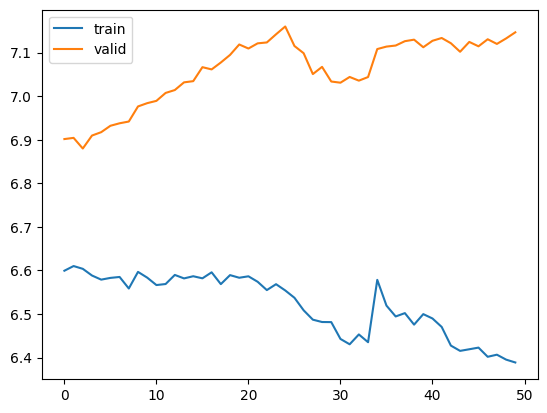

In [ ]:
train_model(config, model)

In [ ]:
torch.save(model, 'my_model.pth')

Treinamento com `batch_size` = 32

In [ ]:
config.update({
    'batch_size': 32
})

EPOCH 1:
  batch 100 loss: 7.172227883338929
  batch 200 loss: 6.641011209487915
  batch 300 loss: 6.622778711318969
LOSS train 6.622778711318969 valid 6.869982719421387
EPOCH 2:
  batch 100 loss: 6.589296593666076
  batch 200 loss: 6.5783744764328
  batch 300 loss: 6.523212966918945
LOSS train 6.523212966918945 valid 6.668927192687988
EPOCH 3:
  batch 100 loss: 6.367052774429322
  batch 200 loss: 6.245095438957215
  batch 300 loss: 6.161773190498352
LOSS train 6.161773190498352 valid 6.4662580490112305
EPOCH 4:
  batch 100 loss: 5.980791273117066
  batch 200 loss: 5.94928249835968
  batch 300 loss: 5.883374304771423
LOSS train 5.883374304771423 valid 6.2536187171936035
EPOCH 5:
  batch 100 loss: 5.765328869819641
  batch 200 loss: 5.708793077468872
  batch 300 loss: 5.647432579994201
LOSS train 5.647432579994201 valid 6.056188583374023
EPOCH 6:
  batch 100 loss: 5.522223701477051
  batch 200 loss: 5.51192259311676
  batch 300 loss: 5.485039143562317
LOSS train 5.485039143562317 valid 

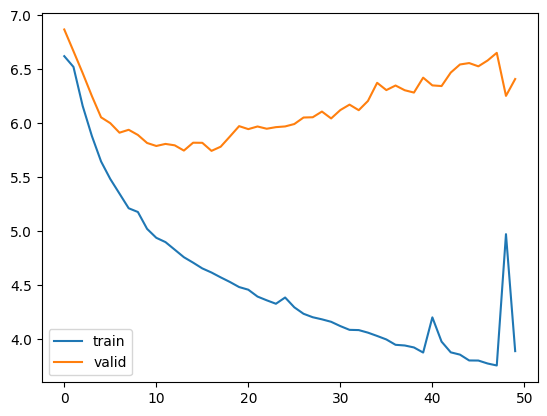

In [ ]:
train_model(config, model)

In [ ]:
torch.save(model, 'my_model2.pth')

## Avaliação do modelo

### Funções de avaliação

Perplexidade

In [49]:
def calculate_perplexity(lm_model, test_dataset):

  lm_model.eval()

  total_loss = []
  with torch.no_grad():
    for inputs in test_dataset:
      input_ids = inputs[0]
      labels = inputs[1]

      # Forward pass through the language model
      logits = lm_model(input_ids)

      # Calculate cross-entropy loss (without reduction)
      loss = F.cross_entropy(logits.view(-1, config['vocab_size']), labels.view(-1))
      total_loss.append(loss.item())

      # Accumulate loss and number of tokens (excluding padding)

  # Calculate average loss and perplexity
  avg_loss = np.mean(total_loss)
  perplexity = np.exp(avg_loss)

  return perplexity.item()


Acurácia

In [72]:
import torch

def calculate_accuracy(model, test_loader):
  """
  Calculates the accuracy of a language model on a test dataset.

  Args:
      model (torch.nn.Module): The language model to evaluate.
      test_loader (torch.utils.data.DataLoader): The test data loader.
      criterion (torch.nn.Module): The loss function used during training.

  Returns:
      float: The accuracy of the model on the test dataset.
  """
  # Set model to evaluation mode
  model.eval()

  # Track variables
  correct = 0
  total = 0

  # No gradient calculation needed during evaluation
  with torch.no_grad():
    for inputs, labels in test_loader:
      outputs = model(inputs)
      predicted = torch.argmax(outputs, dim=-1)  # Get the index of max probability

      # Update counters
      total += labels.numel()
      correct += (predicted == labels).sum().item()


  # Calculate accuracy
  accuracy = correct / total
  return accuracy


### Avaliação dos dois modelos

Modelo 1 (`batch_size` = 16)



In [74]:
model = torch.load('my_model.pth')
model.eval()

ppl = calculate_perplexity(model, test_dataloader)
acc = calculate_accuracy(model, test_dataloader)

print(f"Perplexidade: {ppl}")
print(f"Acurácia: {acc}")

Perplexidade: 880.1006243403579
Acurácia: 0.08547741566609492


Modelo 2 (`batch_size` = 32)



In [75]:
model2 = torch.load('my_model2.pth')
model.eval()

ppl = calculate_perplexity(model, test_dataloader)
acc = calculate_accuracy(model, test_dataloader)

print(f"Perplexidade: {ppl}")
print(f"Acurácia: {acc}")

Perplexidade: 880.1528531595403
Acurácia: 0.08501286449399657


## Gerando compartilhamento no Huggingface

In [76]:
! pip install huggingface_hub

In [83]:
from huggingface_hub import notebook_login

notebook_login()

In [81]:
from huggingface_hub import HfApi
from huggingface_hub.utils import HfHubHTTPError
api = HfApi()
model_repo_name = "gioandrade/llama1_TinyShakespeare"

In [82]:
model_path = '/content/drive/MyDrive/Mestrado/NLP_2024/TP_LLM/my_model2.pth'
torch.save(model2, model_path)

api.upload_folder(
    folder_path='/content/drive/MyDrive/Mestrado/NLP_2024/TP_LLM/',
    repo_id=model_repo_name
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


HfHubHTTPError:  (Request ID: Root=1-668d4a5a-564ed7ba76dfae4e5eb403b3;c12f819b-d5ae-4cd0-b490-5b7bb0a84619)

403 Forbidden: Authorization error..
Cannot access content at: https://huggingface.co/gioandrade/llama1_TinyShakespeare.git/info/lfs/objects/batch.
If you are trying to create or update content,make sure you have a token with the `write` role.